In [172]:
"""Simulation study with Value-Maximizing policy"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

In [173]:
# the orginal task desing for each participatn
behAll = pd.read_csv('/mnt/projects/7TPD/bids/derivatives/fMRI_DA/data_BehModel/originalfMRIbehFiles/AllBehData/rawBehAll.csv')
# Rename an column label
behAll = behAll.rename(columns={'wonAmount                ':'wonAmount'})

In [174]:
# This function generates choice and rewarded choice based in alpha parameters defined in each trial 
# Simulation chooses push and pull in Action value learning condition and yellow and blue in COlor value leanring condition
def simulateActClr(task_design, simName):
    # List of subjects
    subList = ['sub-004', 'sub-010', 'sub-012', 'sub-025', 'sub-026', 'sub-029', 'sub-030',
               'sub-033', 'sub-034', 'sub-036', 'sub-040', 'sub-041', 'sub-042', 'sub-044', 
               'sub-045', 'sub-047', 'sub-048', 'sub-052', 'sub-054', 'sub-056', 'sub-059', 
               'sub-060', 'sub-064', 'sub-065', 'sub-067', 'sub-069', 'sub-070', 'sub-071', 
               'sub-074', 'sub-075', 'sub-076', 'sub-077', 'sub-078', 'sub-079', 'sub-080', 
               'sub-081', 'sub-082', 'sub-083', 'sub-085', 'sub-087', 'sub-088', 'sub-089', 
               'sub-090', 'sub-092', 'sub-108', 'sub-109']
    # Loop over participatns and session, each simulation RL starts from the sratch for each participants and session
    for subName in subList:
        for ses in [1, 2]:
            task_sub_ses = task_design[(task_design['sub_ID']==subName) & (task_design['session']==ses)]
             # Predefined Number of trials
            n_trials = task_sub_ses.shape[0]
            # Predefined conditions for each trial
            block = task_sub_ses.block.to_numpy()
            # Predefined Winning amout of reward for Action and Color options
            winAmtPushable = task_sub_ses.winAmtPushable.to_numpy()
            winAmtPullable = task_sub_ses.winAmtPullable.to_numpy()
            winAmtYellow = task_sub_ses.winAmtYellow.to_numpy()
            winAmtBlue = task_sub_ses.winAmtBlue.to_numpy()  
            # Predefined Correct responces for Action and color options
            pushCorrect = task_sub_ses.pushCorrect.to_numpy()
            yellowCorrect = task_sub_ses.yellowCorrect.to_numpy()
            # Predefined Ground truth Parameters
            alpha = task_sub_ses['alpha'+ simName].to_numpy()
            # Output of simulation for correct choice and Action and Color chosen
            correctChoice = np.zeros(n_trials).astype(int)
            choice = np.zeros(n_trials).astype(int)
            wonAmount = np.zeros(n_trials).astype(int)
            # Initial reward probability
            
            probPush = .5
            probPull = .5
            probYell = .5
            probBlue = .5
            # Loop over trials
            for i in range(n_trials):
                if block[i]=='Act':
                # Compute the Standard Expected Value of each seperated option 
                    expValue1 = probPush*winAmtPushable[i] 
                    expValue2 = probPull*winAmtPullable[i]
                    # Make a binary choice response with value-maximizing policy second step
                    y = int(expValue1>=expValue2)
                    choice[i] = y
                    # Get reward based on the simulated response, third step
                    correctChoice[i] = int(choice[i] == pushCorrect[i])
                    # Get won amount based on the simulated response
                    if choice[i]==1:
                        wonAmount[i] = correctChoice[i]*winAmtPushable[i]
                    elif choice[i] ==0:
                        wonAmount[i] = correctChoice[i]*winAmtPullable[i]
                    # Rl rule update over Action Learning Values for the next trial, fourth step
                    if choice[i] == 1:
                        probPush = probPush + alpha[i]*(correctChoice[i] - probPush)
                        probPull = 1 - probPush           
                    elif choice[i] == 0:
                        probPull = probPull + alpha[i]*(correctChoice[i] - probPull)
                        probPush = 1 - probPull                      
                elif block[i]=='Stim':
                    # Compute the Standard Expected Value of each seperated option 
                    expValue1 = probYell*winAmtYellow[i]
                    expValue2 = probBlue*winAmtBlue[i]
                    # Make a binary choice response with value-maximizing policy
                    y = int(expValue1>=expValue2)
                    choice[i] = y
                    # Get reward based on the simulated response 
                    correctChoice[i] = int(choice[i] == yellowCorrect[i])
                    # Get won amount based on the simulated response
                    if y==1:
                        wonAmount[i] = correctChoice[i]*winAmtYellow[i]
                    elif y==0:
                        wonAmount[i] = correctChoice[i]*winAmtBlue[i]
                    # Rl rule update Color Action Learning values for the next trial
                    if y == 1:
                        probYell = probYell + alpha[i]*(correctChoice[i] - probYell)
                        probBlue = 1 - probYell
                    elif y == 0:
                        probBlue = probBlue + alpha[i]*(correctChoice[i] - probBlue)
                        probYell = 1 - probBlue  
            # output results
            task_design.loc[(task_design['sub_ID']==subName) & (task_design['session']==ses), 'correctChoice_'+simName] = correctChoice
            task_design.loc[(task_design['sub_ID']==subName) & (task_design['session']==ses),'choice_'+simName] = choice
            task_design.loc[(task_design['sub_ID']==subName) & (task_design['session']==ses), 'wonAmount_'+simName] = wonAmount
    return task_design 

# Set the value of alpha parameters for simulating data from RL model
for n in np.linspace(0, 1, 11):
    n = round(n, 1)
    # Put the alpha value into a new column
    behAll['alpha'+str(n)] = n
    # Call simulation function
    behAll = simulateActClr(task_design = behAll, simName=str(n))
 

Text(0, 0.5, 'Total amount')

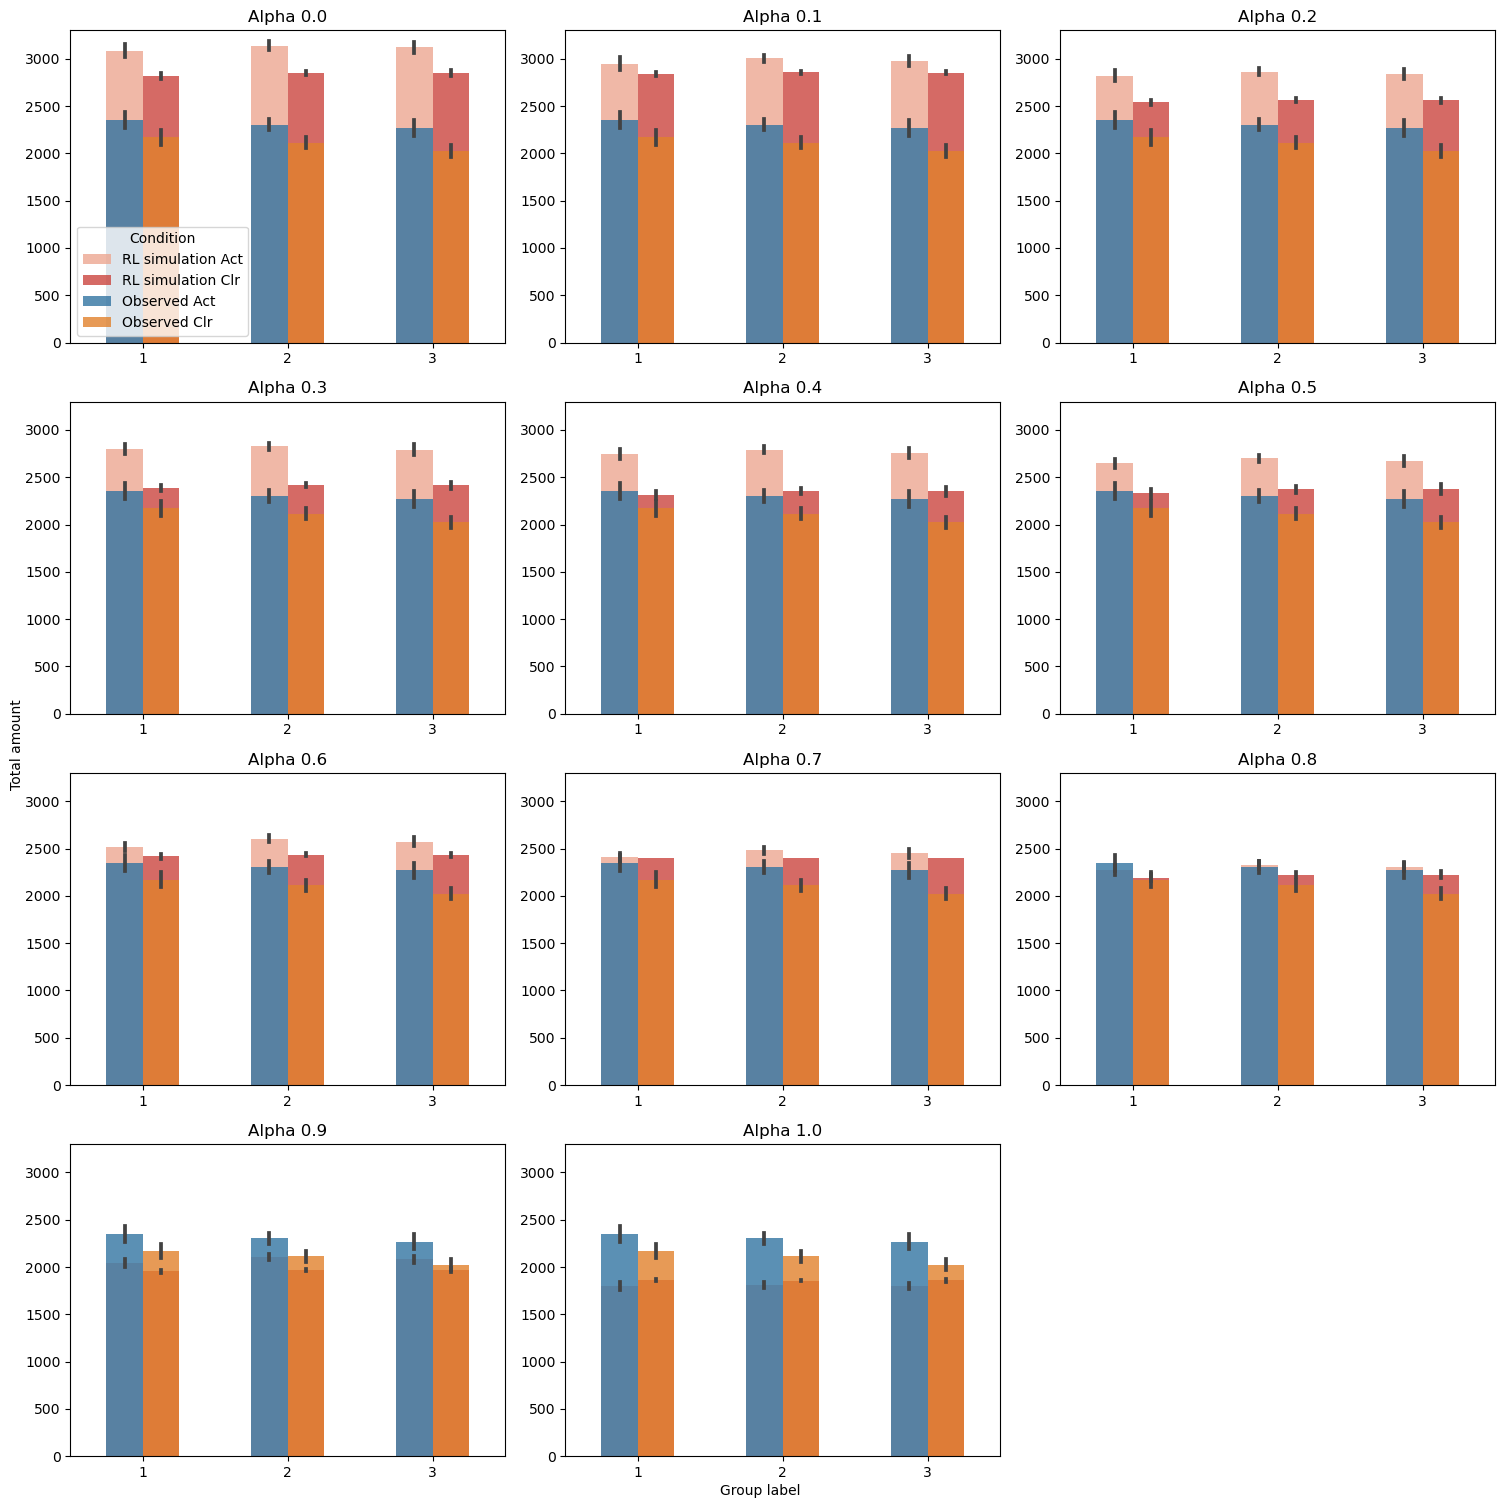

In [171]:
# save subfigure
fig = plt.figure(figsize=(15, 15), tight_layout = True)
nrows= 4
ncols=3
idx = 1
for n in np.linspace(0, 1, 11):
    n = round(n, 1)
    fig.add_subplot(nrows, ncols, idx)
    plt.title('Alpha '+ str(n))
    plt.ylim(0, 3300)

    # toral amount od simulated data by RL
    behAll_wonAmount_agent4 = behAll.groupby(['group', 'block', 'sub_ID'], as_index=False)['wonAmount_'+ str(n)].sum()
    behAll_wonAmount_agent4.loc[behAll_wonAmount_agent4['group']==2,'wonAmount_'+ str(n)] = behAll_wonAmount_agent4[behAll_wonAmount_agent4['group']==2]['wonAmount_'+ str(n)]/2
    sns.barplot(data = behAll_wonAmount_agent4, x='group', y='wonAmount_'+ str(n), hue='block', width=.5, errorbar="se", palette='Reds', alpha=.8)
    # total amount of observed data
    behAll_wonAmount = behAll.groupby(['group', 'block', 'sub_ID'], as_index=False)['wonAmount'].sum()
    behAll_wonAmount.loc[behAll_wonAmount['group']==2,'wonAmount'] = behAll_wonAmount[behAll_wonAmount['group']==2]['wonAmount']/2
    sn = sns.barplot(data = behAll_wonAmount, x='group', y='wonAmount', hue='block', width=.5, errorbar="se", alpha=.8)
    if n==0.0:
        new_title = 'Condition'
        sn.legend_.set_title(new_title)
        for t, l in zip(sn.legend_.texts,['RL simulation Act','RL simulation Clr', 'Observed Act','Observed Clr']):
            t.set_text(l)
    else:
        sn.legend_.remove()
    plt.ylabel('')
    plt.xlabel('')
    # Change the label of legend
    idx+=1
# common x and y label
fig.text(0.5, 0, 'Group label', ha='center')
fig.text(0, 0.5, 'Total amount', va='center', rotation='vertical')

#plt.savefig('./figures/simulation_rl_alpha_won_ammount.png', dpi=300)